# Projet: Identification de la race d'un chien par des modèles de deep learning

## Auteur: Paul COFFI

L'objectif de ce projet est de créer des algorithmes de détection de race de chien à partir d'un modèle de deep learning et d'un jeu de données de 120 races de chiens.

In [1]:
import os
import numpy as np
import pandas as pd  
import torch.nn as nn
import torch, torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from  sklearn.preprocessing import LabelEncoder
import torch.nn.functional as F

### 1. Chargement du jeu de données

In [2]:
lab_df= pd.read_csv('/kaggle/input/big-dawg/labels.csv')
encoder= LabelEncoder()
lab_df['encoded']= encoder.fit_transform(lab_df['breed'])
classes= encoder.classes_
print(classes[0:5])

['affenpinscher' 'afghan_hound' 'african_hunting_dog' 'airedale'
 'american_staffordshire_terrier']


In [3]:
class CustomDataSet(DataLoader):
    def __init__(self, csv_file, root_dir, transform= None):
        self.df= lab_df
        self.root_dir= root_dir
        self.transform= transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name= os.path.join(self.root_dir, self.df.iloc[idx, 0]+ ".jpg")
        img=  Image.open(img_name)
        label= self.df.iloc[idx,2]

        if self.transform:
            img= self.transform(img)

        return img, label

In [4]:
transform=  transforms.Compose([transforms.ToTensor(), transforms.Resize((32,32))])

In [5]:
trainset= CustomDataSet(csv_file= '/kaggle/input/big-dawg/labels.csv', root_dir='/kaggle/input/big-dawg/train', transform= transform)
testset= CustomDataSet(csv_file= '/kaggle/input/big-dawg/labels.csv', root_dir='/kaggle/input/big-dawg/test', transform= transform)

trainloader= DataLoader(trainset, batch_size= 32, shuffle= True)
testloader= DataLoader(testset, batch_size= 32, shuffle= False)

**Affichage des images**

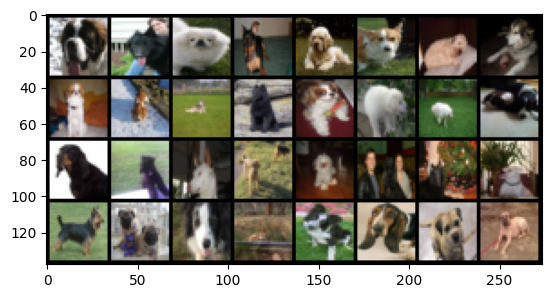

In [6]:


dataiter= iter(trainloader)
images, labels= next(dataiter)

def show_img(img):
    img= np.array(img)
    img= np.transpose(img, (1,2,0))
    plt.imshow(img)
    plt.show()

show_img(torchvision.utils.make_grid(images))
    

In [7]:
print(images.shape), print(labels)

torch.Size([32, 3, 32, 32])
tensor([ 92,  54,  85,  75,  31,  86, 103,  71,  61, 115,  71,  54,  13,  52,
         52,  41,  12,  64,  55,   3, 100,   1,  54,  21,   6,  88,  16,  37,
         16,   8,  17,  25])


(None, None)

**Calcul de la moyenne et de l'écart type pour la normalisation**

In [8]:
mean_= torch.zeros(3)
std_= torch.zeros(3)
n_batch= 0
for data in trainloader:
    img, _= data
    mean_+= img.mean(dim= [0,2,3])
    std_+= img.std(dim= [0,2,3])
    n_batch+= 1

mean_= mean_/n_batch
std_= std_/n_batch

In [9]:
print(mean_), print(std_)

tensor([0.4766, 0.4524, 0.3924])
tensor([0.2393, 0.2347, 0.2392])


(None, None)

In [28]:
transform_final= transforms.Compose([transforms.ToTensor(), transforms.Resize((64,64)), transforms.RandomHorizontalFlip(), transforms.RandomRotation(10), transforms.Normalize((0.4766,0.4524,0.3924),(0.2393,0.2347,0.2392))])

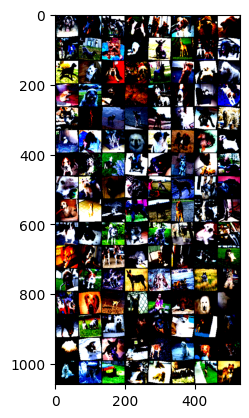

In [29]:
trainset= CustomDataSet( csv_file= '/kaggle/input/big-dawg/labels.csv', root_dir= '/kaggle/input/big-dawg/train' , transform= transform_final)
testset= CustomDataSet( csv_file= '/kaggle/input/big-dawg/labels.csv', root_dir= '/kaggle/input/big-dawg/test' , transform= transform_final)

trainloader= DataLoader(trainset, batch_size= 128, shuffle= True)
testloader= DataLoader(testset, batch_size= 128, shuffle= False)

classes= pd.read_csv('/kaggle/input/big-dawg/labels.csv')['breed']
encoder= LabelEncoder()
class_label= encoder.fit_transform(classes)


dataiter= iter(trainloader)
img_, lab= next(dataiter)

def shw_img(img):
    imgnp= img.numpy()
    imgnp= np.transpose(imgnp, (1,2,0))
    
    plt.imshow(imgnp)
    plt.show()


shw_img(torchvision.utils.make_grid(img_))

In [30]:
print(img_.shape)

torch.Size([128, 3, 64, 64])


### 2. Implémentation d'un premier modèle personnalisé 

In [37]:
class CNNModel(nn.Module):
    def __init__(self, num_classes= 120):
        super().__init__()
        self.conv1= nn.Conv2d(in_channels=3, out_channels= 5, kernel_size= 3, stride= 1) # 5*62*62
        self.pool1= nn.MaxPool2d(kernel_size=2, stride= 2) # 5*31*31
        self.conv2= nn.Conv2d(in_channels= 5, out_channels= 8, kernel_size= 4, stride= 1) #8*28*28
        self.pool2= nn.MaxPool2d(kernel_size= 2, stride= 2) # 8*14*14
        self.conv3= nn.Conv2d(in_channels= 8, out_channels= 4, kernel_size= 3, stride= 1) #4*12*12
        self.pool3= nn.MaxPool2d(kernel_size= 2, stride= 2) #4*6*6
        self.fc1= nn.Linear(4*6*6, 200)
        self.fc2= nn.Linear(200, 150)
        self.fc3= nn.Linear(150, 120)

    def forward(self, x):
        x= self.pool1(F.relu(self.conv1(x)))
        x= self.pool2(F.relu(self.conv2(x)))
        x= self.pool3(F.relu(self.conv3(x)))
        x= x.view(x.size(0), -1)
        x= F.relu(self.fc1(x))
        x= F.relu(self.fc2(x))
        x= self.fc3(x)

        return x

In [38]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model= CNNModel()
model= model.to(device)
criterion= nn.CrossEntropyLoss()
criterion= criterion.to(device)
optimizer= torch.optim.Adam(model.parameters(), lr= 0.0001)

In [ ]:
losses= []
epochs= 750
for epoch in range(epochs):
    for data in trainloader:
        img_in, label= data
        img_in, label= img_in.to(device), label.to(device)
        img_out= model.forward(img_in)
        loss= criterion(img_out, label)
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch+1)%1== 0:
        print("epoch: "+ str(epoch+1)+ " erreur: "+ str(loss.item()))

epoch: 1 erreur: 4.793456077575684
epoch: 2 erreur: 4.770327091217041
epoch: 3 erreur: 4.701985836029053
epoch: 4 erreur: 4.69173526763916
epoch: 5 erreur: 4.610496520996094
epoch: 6 erreur: 4.481540679931641
epoch: 7 erreur: 4.456252574920654
epoch: 8 erreur: 4.357651710510254
epoch: 9 erreur: 4.574817657470703
epoch: 10 erreur: 4.461179256439209
epoch: 11 erreur: 4.455462455749512
epoch: 12 erreur: 4.439655303955078
epoch: 13 erreur: 4.443075656890869
epoch: 14 erreur: 4.42706823348999
epoch: 15 erreur: 4.417913436889648
epoch: 16 erreur: 4.513627529144287
epoch: 17 erreur: 4.350650787353516
epoch: 18 erreur: 4.363745212554932
epoch: 19 erreur: 4.433295726776123
epoch: 20 erreur: 4.278045177459717
epoch: 21 erreur: 4.398287296295166
epoch: 22 erreur: 4.3681840896606445
epoch: 23 erreur: 4.232781410217285
epoch: 24 erreur: 4.396634578704834
epoch: 25 erreur: 4.321075916290283
epoch: 26 erreur: 4.296522617340088
epoch: 27 erreur: 4.321281433105469
epoch: 28 erreur: 4.246809482574463
ep

L'entrainement prend du temps je vais donc continuer le travail en évaluant sur le test quand j'aurais du temps.
On observe tout de meme que la fonction de perte est décroissante va peut etre converger.
Dans la suite, je vais implémenter le resnet50 pour les memes taches.